In [1]:
from validphys.api import API
import matplotlib.pyplot as plt
import sys
import re
from collections import namedtuple

# Add the path to the library folder
sys.path.append('./lib')

from model import PDFmodel
#from gen_dicts import generate_dicts
from validphys.api import API
from matplotlib.colors import LogNorm

import numpy as np
import pandas as pd

In [2]:
seed = 14132124

In [6]:
def generate_dicts(groups_data):

  # Initialize named tuple
  result_tuple = namedtuple('result_tuple', ('fk_tables', 'central_data', 'xgrid', 'total_ndata_wc'))

  # Initialise the dictionaries
  fk_table_dict = {}
  central_data_dict = {}

  XGRID = np.array([])

  total_ndata_wc = 0
  for group_proc in groups_data:
    for exp_set in group_proc.datasets:
      dataset_name = exp_set.name
      dataset_size = exp_set.load_commondata().ndata
      total_ndata_wc += dataset_size
      cuts = exp_set.cuts
      central_data_dict[dataset_name] = exp_set.load_commondata().with_cuts(cuts).central_values.to_numpy()

      # Collect FKSpecs
      fk_data = exp_set.fkspecs[0].load_with_cuts(cuts)

      # Read FKData and FK table in numpy version
      fk_table = fk_data.get_np_fktable()
      fk_table_dict[dataset_name] = fk_table

      # xgrid for this dataset
      xgrid = fk_data.xgrid
      if xgrid.size > XGRID.size:
        XGRID = xgrid

      # Check that `large_xgrid` is just a small-x extension of xgrid
      for i, x in enumerate(xgrid):
        offset = XGRID.size - xgrid.size
        try:
          assert(np.isclose(x, XGRID[offset+i]))
        except AssertionError:
          print(f"`large_xgrid` is not an extension for {dataset_name}.")

  res = result_tuple(fk_tables=fk_table_dict, central_data=central_data_dict, xgrid=XGRID, total_ndata_wc=total_ndata_wc)
  return res


def pad_fk_tables(fk_table_dict, grid_size):
  res_dict = {}
  for dataset_name, fk_table in fk_table_dict.items():
    res_dict[dataset_name] = np.pad(fk_table, ((0, 0), (0,0), (grid_size - fk_table.shape[2], 0)), 'constant')
  return res_dict


def build_fk_matrix(fk_dict):
   """
   Construct the FK table matrix.

   Description
   -----------
   Each experiment is provided with an FK table. By construction, and
   for the present work, FK tables are padded with zeros such that
   the number of points in the x-grid is the same (i.e. 50). Thus,
   each FK table has shape (Ndat, 50, 9). First, the last two dimensions
   (which are equal for all FK tables) are flattened, thus leaving 
   the shape (Ndat, 450). Then, all FK tables are stacked together,
   yielding a matrix (tot_Ndat, 450), where `tot_Ndata` is the sum
   off all experimental point. In this way, each row of this matrix
   represents an experimental point and contains the information to
   compute its relative theoretical prediction.

   Parameters
   ----------
   fk_dict: dict
    Dictionary of FK tables.
   """
   ndata = 0
   for fk in fk_dict.values():
      ndata += fk.shape[0]

   FK = np.vstack([fk.reshape((fk.shape[0], fk.shape[1] * fk.shape[2])) for fk in fk_dict.values()])

   # Check that this FK is what we expect
   try:
     test_matrix = np.random.rand(FK.shape[0], FK.shape[0]) # Random matrix
     mat_prod = FK.T @ test_matrix  # Matrix product
 
     # Tensor product
     result = np.zeros((fk.shape[1], fk.shape[2], FK.shape[0]))
     I = 0
     for fk in fk_dict.values():
       ndata = fk.shape[0]
       result += np.einsum('Iia, IJ -> iaJ',fk, test_matrix[I : I + ndata, :])
       I += ndata
     
     result_flatten = result.reshape((result.shape[0] * result.shape[1], result.shape[2]))
     assert(np.allclose(result_flatten, mat_prod))
     assert(np.allclose(result, mat_prod.reshape((result.shape[0], result.shape[1], result.shape[2]))))
   except AssertionError:
     print('The FK matrix does not match with the FK dict.')
   else:
      return FK

In [80]:
# List of DIS dataset
dataset_inputs = [
  #{'dataset': 'NMC_NC_NOTFIXED_P_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'SLAC_NC_NOTFIXED_P_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'SLAC_NC_NOTFIXED_D_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'BCDMS_NC_NOTFIXED_P_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'BCDMS_NC_NOTFIXED_D_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'CHORUS_CC_NOTFIXED_PB_NU-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'CHORUS_CC_NOTFIXED_PB_NB-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'NUTEV_CC_NOTFIXED_FE_NU-SIGMARED', 'cfac': ['MAS'], 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'NUTEV_CC_NOTFIXED_FE_NB-SIGMARED', 'cfac': ['MAS'], 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'HERA_NC_225GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'HERA_NC_251GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'HERA_NC_300GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'HERA_NC_318GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'HERA_CC_318GEV_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'HERA_CC_318GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'HERA_NC_318GEV_EAVG_CHARM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'HERA_NC_318GEV_EAVG_BOTTOM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
]

# Dictionary for validphys API
common_dict = dict(
    dataset_inputs=dataset_inputs,
    metadata_group="nnpdf31_process",
    use_cuts='internal',
    datacuts={'q2min': 3.49, 'w2min': 12.5},
    theoryid=708,
    t0pdfset='NNPDF40_nnlo_as_01180',
    use_t0=True
)

In [81]:
# Retrieve data from NNPDF
groups_data = API.procs_data(**common_dict)
tuple_of_dicts = generate_dicts(groups_data)
fk_table_dict = tuple_of_dicts.fk_tables
central_data_dict = tuple_of_dicts.central_data
XGRID = tuple_of_dicts.xgrid

fk_table_dict_padded = pad_fk_tables(fk_table_dict, XGRID.size)
FK = build_fk_matrix(fk_table_dict_padded)

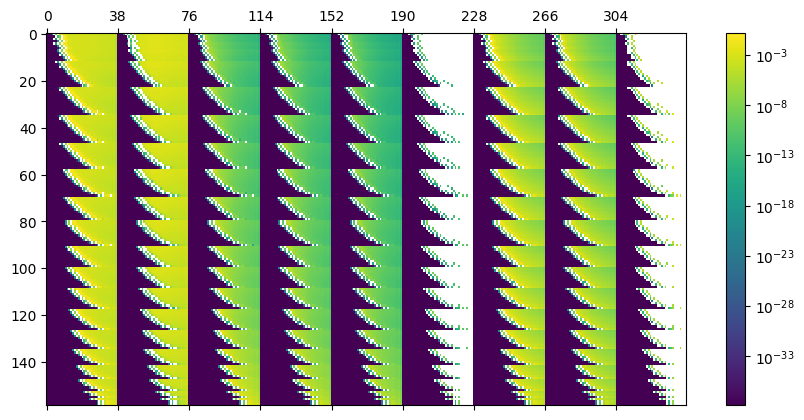

In [82]:
matshow = plt.matshow(FK, aspect='auto', norm=LogNorm())
plt.colorbar(matshow)
_ = plt.xticks(np.arange(0, FK.shape[1], XGRID.size))

In [83]:
C = API.groups_covmat_no_table(**common_dict)
Cinv = pd.DataFrame(np.linalg.inv(C), index=C.index, columns=C.columns)

# Diagonalize covariance matrix
eigvals_Cinv, R_Y = np.linalg.eigh(Cinv)
if eigvals_Cinv[-1] > eigvals_Cinv[0]:
    eigvals_Cinv = eigvals_Cinv[::-1]
    R_Y = R_Y[:,::-1]
D_Y = np.diag(eigvals_Cinv)

In [84]:
# Construct dataframe for predictions
Y = pd.DataFrame(np.zeros(Cinv.shape[0]), index=Cinv.index)
for exp_name, data in central_data_dict.items():
  if data.size == Y.loc[(slice(None), [exp_name], slice(None)), :].size:
    # (group, experiment, index)
    Y.loc[(slice(None), [exp_name], slice(None)), :] = data
  else:
    raise ValueError

In [85]:
nnpdf_model = PDFmodel(input=XGRID,
                       outputs=9,
                       architecture=[28,20],
                       activations=['tanh', 'tanh'],
                       kernel_initializer='RandomNormal',
                       user_ki_args={'mean': 0.0, 'stddev': 1.0},
                       seed=seed,
                       dtype='float64')
NTK = nnpdf_model.compute_ntk()

# Flatten NTK
prod = 1
oldshape = NTK.shape
for k in oldshape[2:]:
    prod *= k
NTK_flat = np.array(NTK).reshape(prod,-1)

# Compute predictions at initialization
f0 = nnpdf_model.predict(squeeze=True)

# Computing matrices from notes
-------------------------------

In [86]:
def regularize_matrix_svd(M, hermitean: bool = False, tol: float = None):
   """
   Regularization of a matrix wither with svd or evd depending
   on whether the matrix is symmetric or not.

   Description
   -----------
   When dealing with numerical precision issues in matrices (e.g. symmetric 
   matrices with eigenvalues spanning a very large range) regularization turns
   out to be essential. If the matrix is symmetric, the regularization is applied
   to the eigenvalues; if the matrix is not symmetric, the regularization is
   applied to the singular values. The tolerance, which defines the smallest
   distinguishable difference, is eps * max(s) where eps is the machine epsilon
   (~2.2e-16 for float64) and max(s) is the highest eigenvalue or the highest
   singular value.

   Parameters
   ----------
   M: np.ndarray
    The matrix that needs to be regularized. The matrix must be squared.
   tol: float
    The tolerance that defines the smallest distinguishable value. Default is None,
    and the tolerance is defined as eps * max(s).

   Returns
   -------
   If the matrix is symmetric, it returns the regularized matrix and a tuple
   containing the regularized eigenvalues in first position and the respective
   eigenvectors in second position. If the matrix is not symmetric, it returns
   the regularized matrix, and a tuple (U, S_reg, Vh).
   """
   U, S, Vh = np.linalg.svd(M, full_matrices=False, hermitian=hermitean)
   if tol is None:
     tol = np.amax(S, initial=0.) * np.finfo(M.dtype).eps
   reg_S = np.where(S > tol, S, 0.0)
   M_reg = np.dot(U * reg_S, Vh)
      
   return M_reg, (reg_S, Vh, U, tol)

# $M = (FK)^T C_Y^{-1} (FK) = RDR^T$
Here I compute the matrix $M$ as defined above. Then I check that the SVD gives the same result as the eigen decomposition

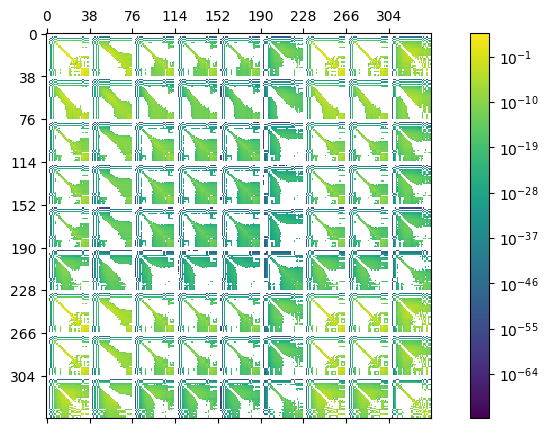

In [87]:
# Compute M and make a copy
M = FK.T @ Cinv.to_numpy() @ FK
FK_full = FK.copy()
M_full = M.copy()

assert(np.allclose(M, M.T))

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
matshow = ax.matshow(M_full, norm=LogNorm())
ax.set_xticks(np.arange(0, M_full.shape[1], XGRID.size))
ax.set_yticks(np.arange(0, M_full.shape[0], XGRID.size))
_ = fig.colorbar(matshow, ax=ax)

Remove rows and columns that are entirely zeros (also for $FK$)

In [88]:
# Define tolerance for comparison
tol = np.amax(M, initial=0.) * np.finfo(M.dtype).eps

# Remove zero rows
#M = M[~np.all(np.isclose(M,0, atol=tol), axis=1)]

# Remove zero columns
#M = M[:, ~np.all(np.isclose(M,0, atol=tol), axis=0)]
#FK = FK[:, ~np.all(np.isclose(FK,0, atol=0.22*tol), axis=0)] # 0.22 is a magic number

# Print shape after removing zero rows and columns
#print(f"Shape after removing zero rows and columns from M: {M.shape}")
#print(f"Shape after removing zero columns from (FK): {FK.shape}")

# Compute SVD
U_M, S_M, Vh_M = np.linalg.svd(M, full_matrices=True, hermitian=True)
V_M = Vh_M.T
print(f"Max. singular value : {S_M[0]:.2e}")

# Compute the eigensystem of the regularized matrix
eigvals_M, eigvecs_M = np.linalg.eigh(M)
eigvals_M = eigvals_M[::-1]
eigvecs_M = eigvecs_M[:, ::-1]

# Plot matrix in logscale
# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# mat0 = ax.matshow(M, norm=LogNorm())
# _ = fig.colorbar(mat0, ax=ax)

Max. singular value : 1.31e+04


Compare the singular values with the eigenvalues. These should match, and the difference between them is noise. Noise should show up below the tolerance (relative to the highest singular value).

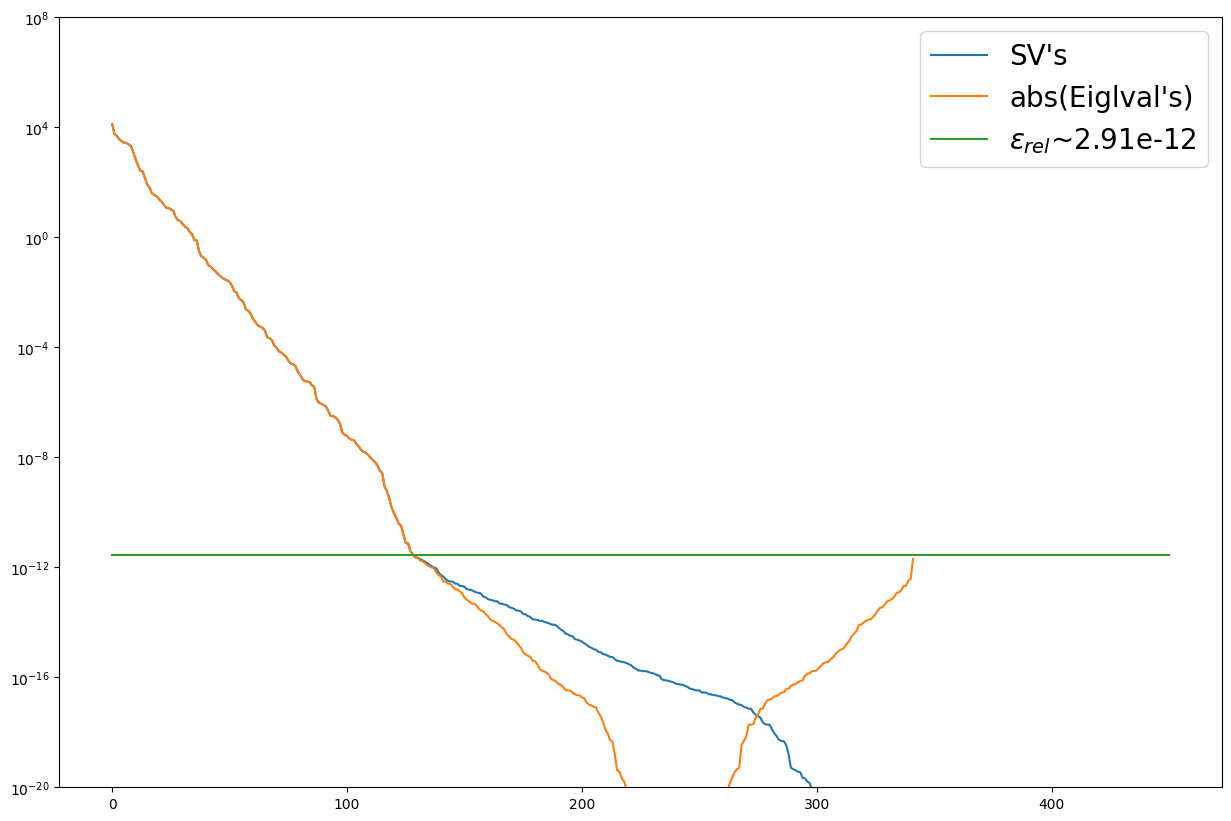

In [89]:
eps = np.finfo(M.dtype).eps
eps_rel_M = eps * S_M[0]

plt.figure(figsize=(15,10))
plt.plot(S_M, label="SV's")
plt.plot(np.abs(eigvals_M), label="abs(Eiglval's)")
plt.plot(np.linspace(0,450,100), [eps_rel_M for _ in range(100)], label=r'$\varepsilon_{rel}$' +  f'~{eps_rel_M:.2e}')
#plt.xscale('log')
plt.yscale('log')
plt.ylim([1.e-20,1.e8])
plt.legend(fontsize=20)

In this cell, it is possible to regularise $M$ by introducing a diagonal regularisation. Then, computes the SVD for the regularised matrix.

In [90]:
# Regularize the matrix
M_reg, (S_M_reg, Vh_M, U_M, tol) = regularize_matrix_svd(M, tol=eps_rel_M, hermitean=True)

# Regularize the eigenvalues
eigvals_M = [val if val > eps_rel_M else 0.0 for val in eigvals_M]

# Compute the pseudo-inverse
M_pinv = np.linalg.pinv(M_reg, rcond=eps)

# Reconstruct the pseudo-inverse
S_M_reg_dag = [1/val if val != 0.0 else 0.0 for val in S_M_reg]
M_my_pinv = Vh_M.T @ np.diag(S_M_reg_dag) @ U_M.T

Check that $S$ and $S^{\dag}$ are orthogonal using `plt.spy`.

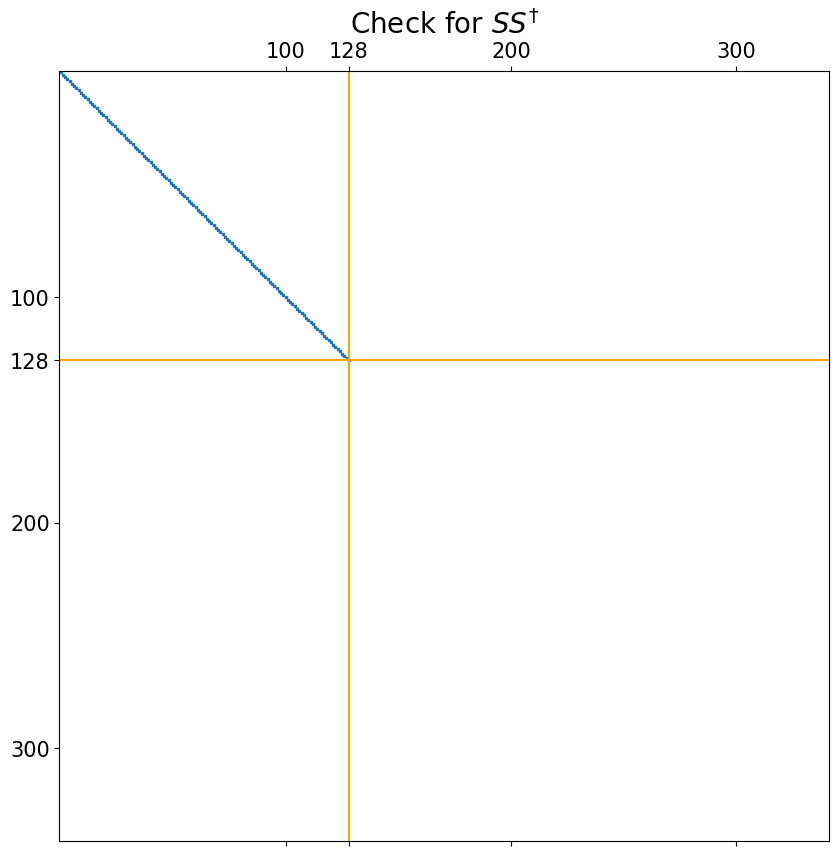

In [91]:
last_non_zero = np.where(np.diag(S_M_reg_dag) @ np.diag(S_M_reg) > eps_rel_M)[-1][-1]

plt.figure(figsize=(15,10))
plt.spy(np.diag(S_M_reg_dag) @ np.diag(S_M_reg), precision=eps_rel_M, markersize=2)
plt.plot(np.linspace(0,M.shape[0],100), [last_non_zero for _ in range(100)], label=r'$\varepsilon_{rel}$' +  f'~{eps_rel_M:.2e}', color='orange')
plt.plot([last_non_zero for _ in range(100)], np.linspace(0,M.shape[0],100), label=r'$\varepsilon_{rel}$' +  f'~{eps_rel_M:.2e}', color='orange')
_ = plt.xticks(ticks=[100, 200, 300, last_non_zero], fontsize=15)
_ = plt.yticks(ticks=[100, 200, 300, last_non_zero], fontsize=15)
_ = plt.title(r"Check for $S  S^{\dag}$", fontsize=20)

Check that $U$ and $V$ are orthogonal (separately)

In [92]:
is_U_orth = np.allclose(U_M.T @ U_M, np.eye(U_M.shape[0]), atol=eps_rel_M)
is_V_orth = np.allclose(Vh_M.T @ Vh_M, np.eye(Vh_M.shape[0]), atol=eps_rel_M)
print(f"U is orthogonal: {is_U_orth}")
print(f"V is orthogonal: {is_V_orth}")

U is orthogonal: True
V is orthogonal: True


Check that $U^T U = 1$ and $V^T V = 1$ using `plt.spy`

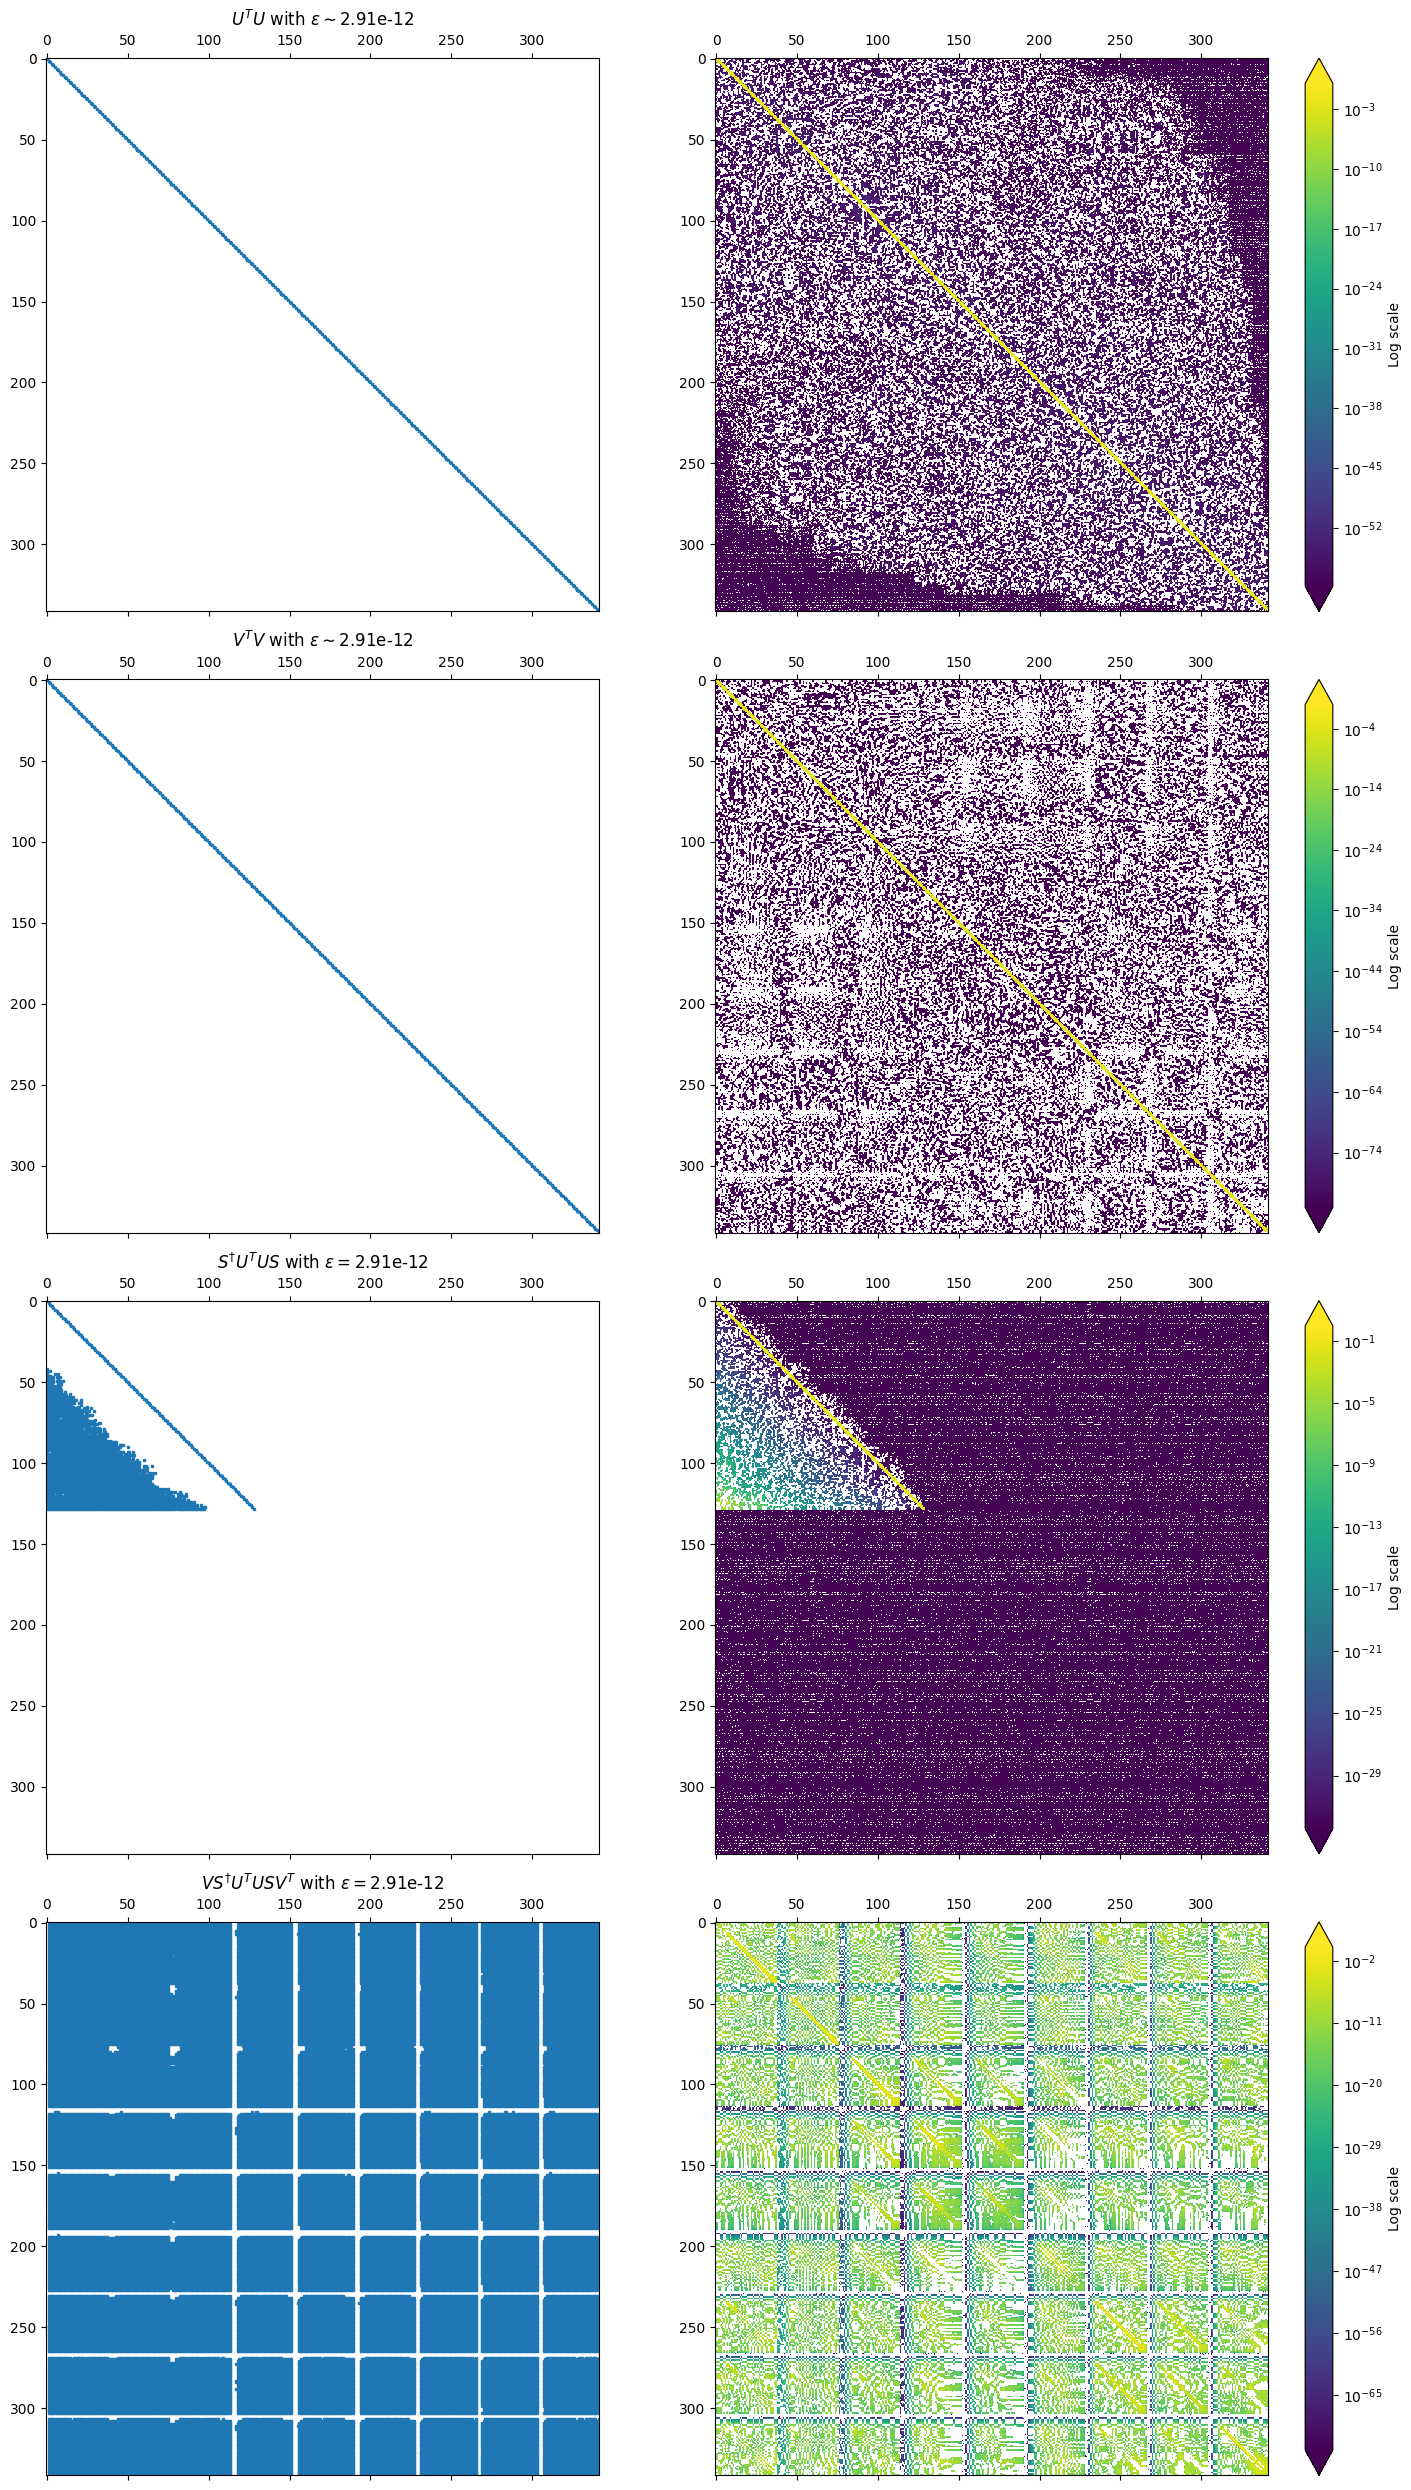

In [93]:
fig, axs = plt.subplots(4, 2, figsize=(15,25))

axs[0,0].spy(U_M.T @ U_M, precision=eps_rel_M, markersize=2)
axs[0,0].set_title(r'$U^T U$ with $\epsilon \sim$' + f'{eps_rel_M:.2e}')
im = axs[0,1].matshow(U_M.T @ U_M, cmap='viridis', norm=LogNorm(), interpolation='kaiser',)
cbar = fig.colorbar(im, extend='both', ax=axs[0,1])
cbar.set_label('Log scale')

axs[1,0].spy(Vh_M.T @ Vh_M, precision=eps_rel_M, markersize=2)
axs[1,0].set_title(r'$V^T V$ with $\epsilon \sim$' + f'{eps_rel_M:.2e}')
im = axs[1,1].matshow(Vh_M.T @ Vh_M, cmap='viridis', norm=LogNorm(), interpolation='kaiser',)
cbar = fig.colorbar(im, extend='both', ax=axs[1,1])
cbar.set_label('Log scale')

axs[2,0].spy(np.diag(S_M_reg_dag) @ (U_M.T @ U_M) @ np.diag(S_M_reg), precision=eps_rel_M, markersize=2)
axs[2,0].set_title(r'$S^{\dag} U^T U S$ with $\epsilon =$' + f'{eps_rel_M:.2e}')
im = axs[2,1].matshow(np.diag(S_M_reg_dag) @ (U_M.T @ U_M) @ np.diag(S_M_reg), cmap='viridis', norm=LogNorm(), interpolation='kaiser',)
cbar = fig.colorbar(im, extend='both', ax=axs[2,1])
cbar.set_label('Log scale')

axs[3,0].spy(Vh_M.T @ np.diag(S_M_reg_dag) @ (U_M.T @ U_M) @ np.diag(S_M_reg) @ Vh_M, precision=eps_rel_M, markersize=2)
axs[3,0].set_title(r'$V S^{\dag} U^T U S V^T$ with $\epsilon =$' + f'{eps_rel_M:.2e}')
im = axs[3,1].matshow(Vh_M.T @ np.diag(S_M_reg_dag) @ (U_M.T @ U_M) @ np.diag(S_M_reg) @ Vh_M, cmap='viridis', norm=LogNorm(), interpolation='kaiser',)
cbar = fig.colorbar(im, extend='both', ax=axs[3,1])
cbar.set_label('Log scale')

fig.tight_layout()
match = re.search(r'e([+-]?\d+)', str(eps_rel_M))
#fig.savefig(f"./new_plots/reg_M_dag_{match.group(1)[1:]}.pdf")

Check that $M^{\dag} M \approx 1$

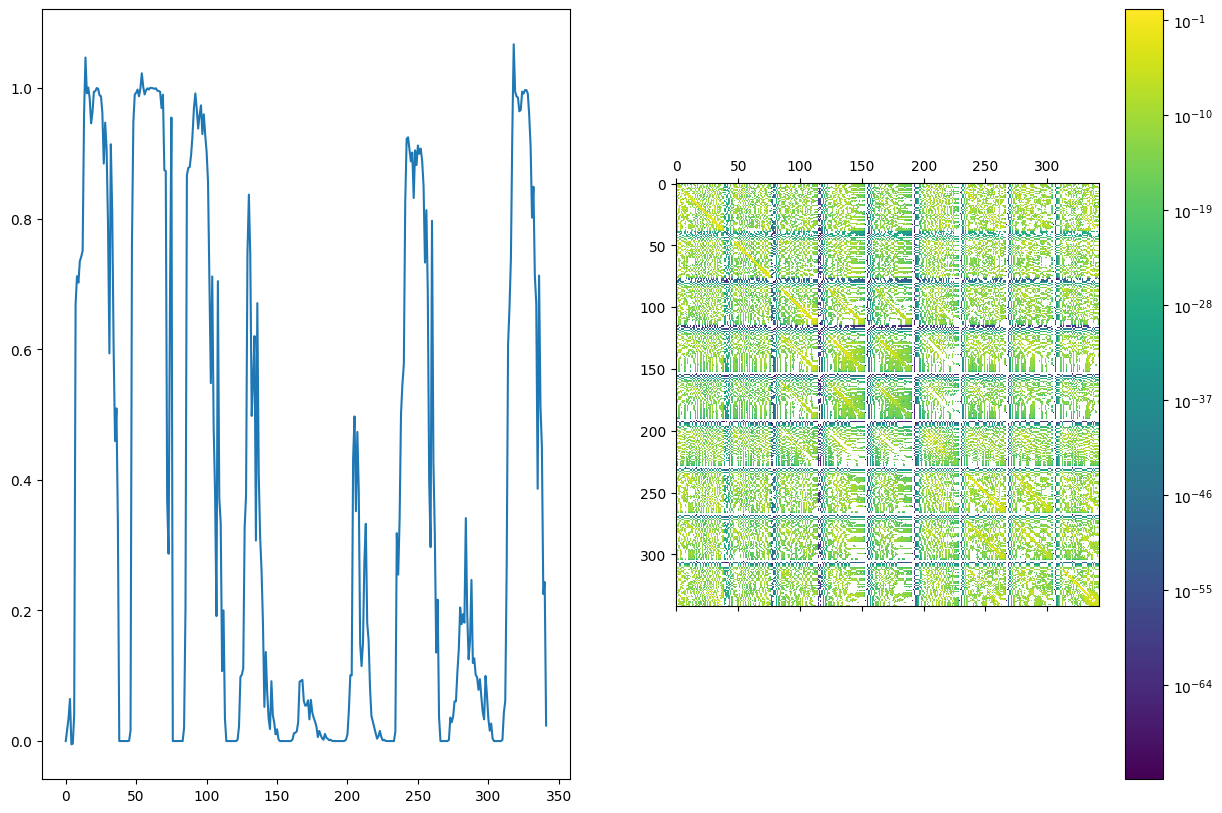

In [94]:
test = M_reg @ M_pinv
fig, axs = plt.subplots(1, 2, figsize=(15,10))

axs[0].plot(test.diagonal(), label='Diagonal')
#axs[0].set_yscale('log')

matshow = axs[1].matshow(test, cmap='viridis', norm=LogNorm(), interpolation='kaiser')
fig.colorbar(matshow, ax=axs[1], location='right')

Trying to reconstruct $M_{\rm{reg}}$

M_rec - M_reg ?= 0 : True 


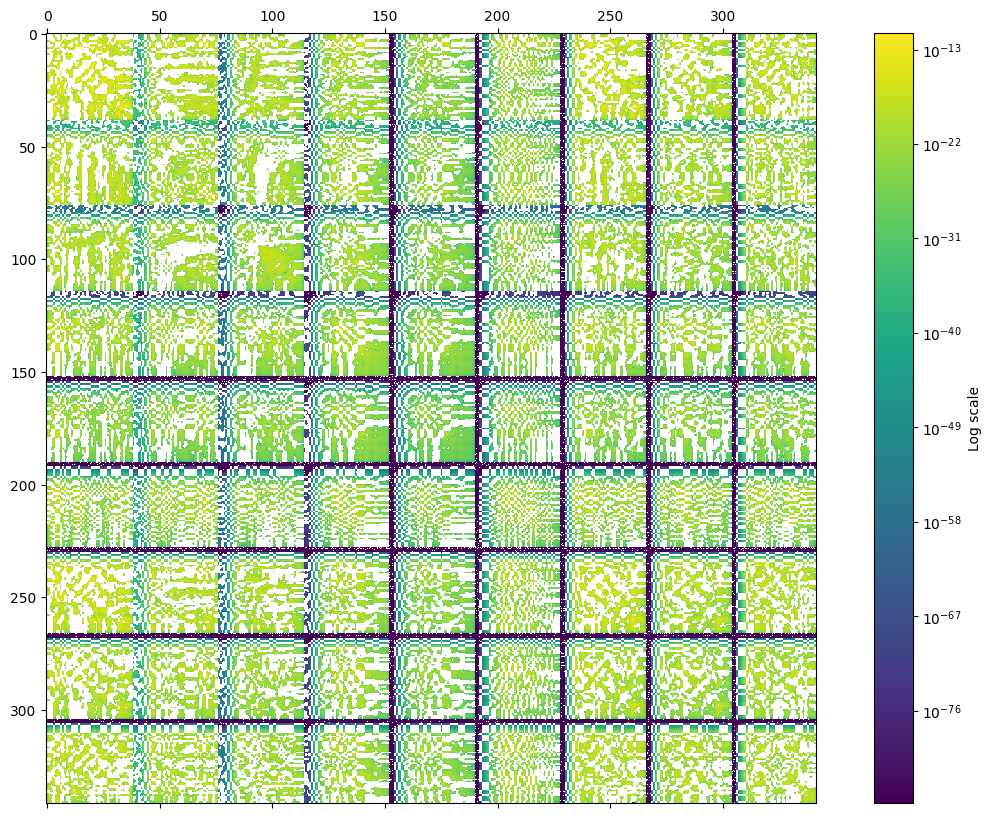

In [95]:
# Compute the regularisation of (FK) induced by M
#FK_reg = FK #+ reg_eta * FK @ eigvecs_M @ np.diag(S_M_reg_dag) @ eigvecs_M.T 

M_rec = FK.T @ Cinv.to_numpy() @ FK
diff = M_rec - M_reg

fig, ax = plt.subplots(1, 1, figsize=(15,10))
matshow = ax.matshow(diff, cmap='viridis', norm=LogNorm(), interpolation='kaiser')
fig.colorbar(matshow, ax=ax, shrink=1.0, location='right', label='Log scale')

print(f"M_rec - M_reg ?= 0 : {np.allclose(diff, np.zeros_like(diff))} ")

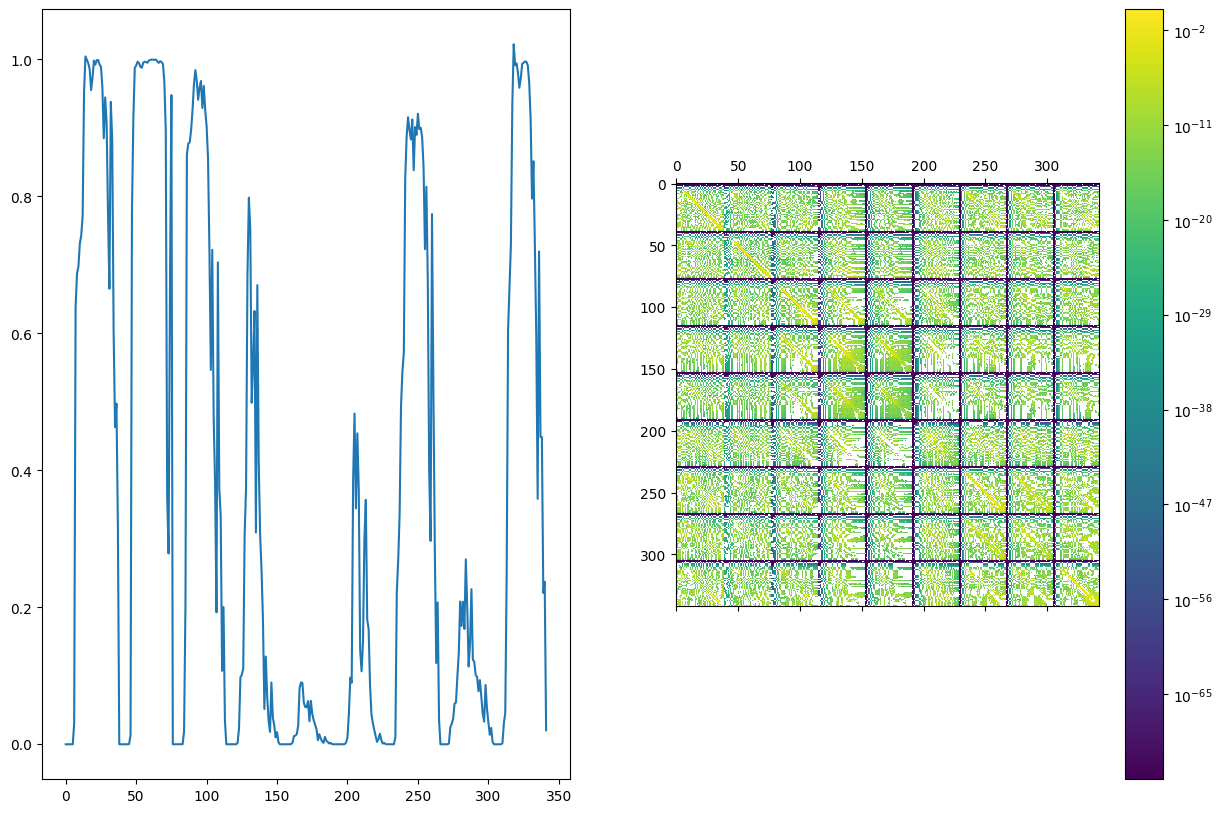

In [96]:
M_M_pinv_test = M_rec @ M_my_pinv
fig, axs = plt.subplots(1, 2, figsize=(15,10))

axs[0].plot(M_M_pinv_test.diagonal(), label='Diagonal')
#axs[0].set_yscale('log')

matshow = axs[1].matshow(M_M_pinv_test, cmap='viridis', norm=LogNorm(), interpolation='kaiser')
fig.colorbar(matshow, ax=axs[1], location='right')

# $\tilde{H} = D^{1/2} R^T \Theta R D^{1/2}$

In [97]:
D = np.diag(S_M_reg)
# ntk = NTK_flat[~np.all(np.isclose(M_full, 0, atol=tol), axis=1)]
# ntk = ntk[:, ~np.all(np.isclose(M_full ,0, atol=tol), axis=0)]
ntk = NTK_flat

# Compute H_tilde
H_tilde = np.sqrt(D) @ eigvecs_M.T @ ntk @ eigvecs_M @ np.sqrt(D)

# Compute SVD
U_Ht, S_Ht, Vh_Ht = np.linalg.svd(H_tilde, full_matrices=True, hermitian=True)

print(f"Max. singular value : {S_Ht[0]:.2e}")
assert(np.allclose(H_tilde, H_tilde.T))

Max. singular value : 5.07e+04


In [98]:
# Compute eigensystem
eigvals_Ht, eigvecs_Ht = np.linalg.eigh(H_tilde)
eigvals_Ht = eigvals_Ht[::-1]
eigvecs_Ht = eigvecs_Ht[:, ::-1]

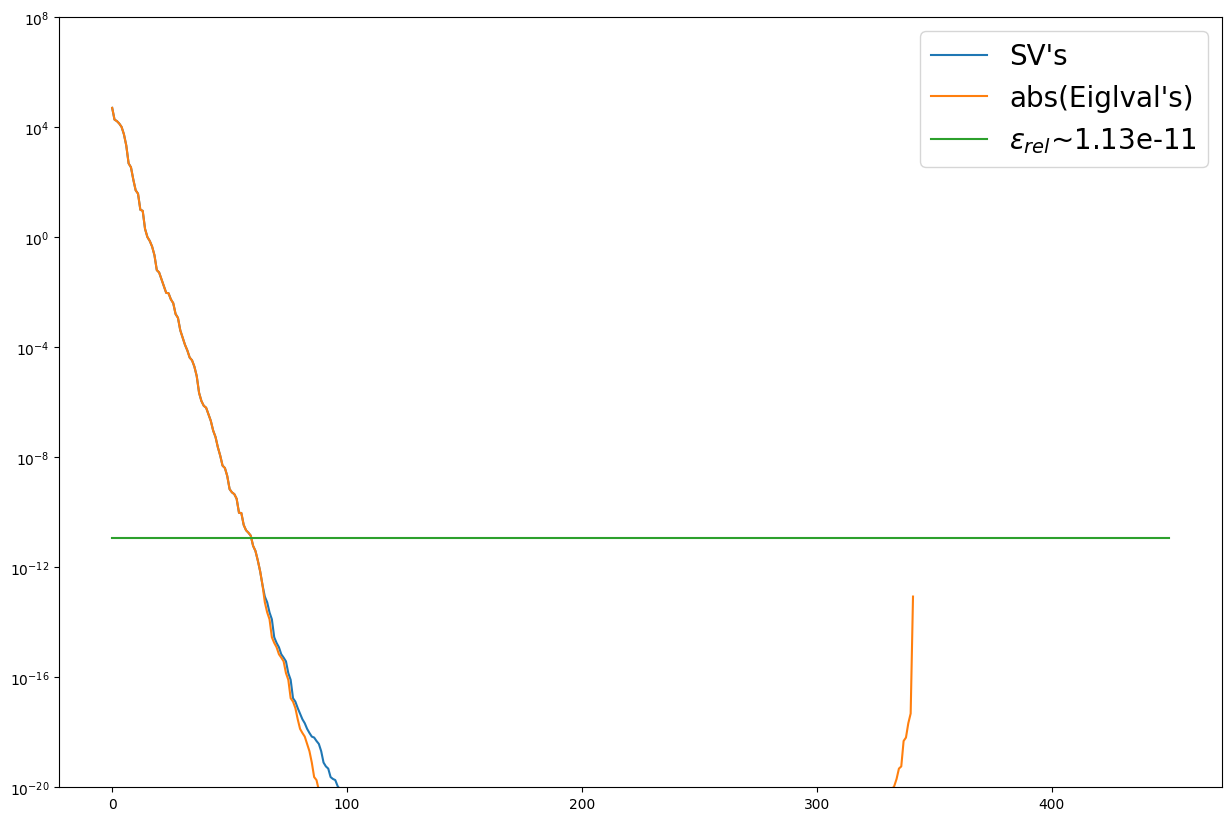

In [99]:
eps_rel_Ht = eps * S_Ht[0]

plt.figure(figsize=(15,10))
plt.plot(S_Ht, label="SV's")
plt.plot(np.abs(eigvals_Ht), label="abs(Eiglval's)")
plt.plot(np.linspace(0,450,100), [eps_rel_Ht for _ in range(100)], label=r'$\varepsilon_{rel}$' +  f'~{eps_rel_Ht:.2e}')
#plt.xscale('log')
plt.yscale('log')
plt.ylim([1.e-20,1.e8])
plt.legend(fontsize=20)

Compute SVD of the regularization of $\tilde{H}$

In [100]:
# Regularize the matrix
H_tilde_reg, (S_ht_reg, Vh_ht, U_ht, tol) = regularize_matrix_svd(H_tilde, tol=eps_rel_Ht, hermitean=True)

# Regularize the eigenvalues
eigvals_M = [val if val > eps_rel_Ht else 0.0 for val in eigvals_Ht]

# Compute the pseudo-inverse
ht_pinv = np.linalg.pinv(H_tilde_reg, rcond=eps)

# Reconstruct the pseudo-inverse
S_ht_reg_dag = [1/val if val != 0.0 else 0.0 for val in S_ht_reg]
ht_my_pinv = Vh_ht.T @ np.diag(S_ht_reg_dag) @ U_ht.T

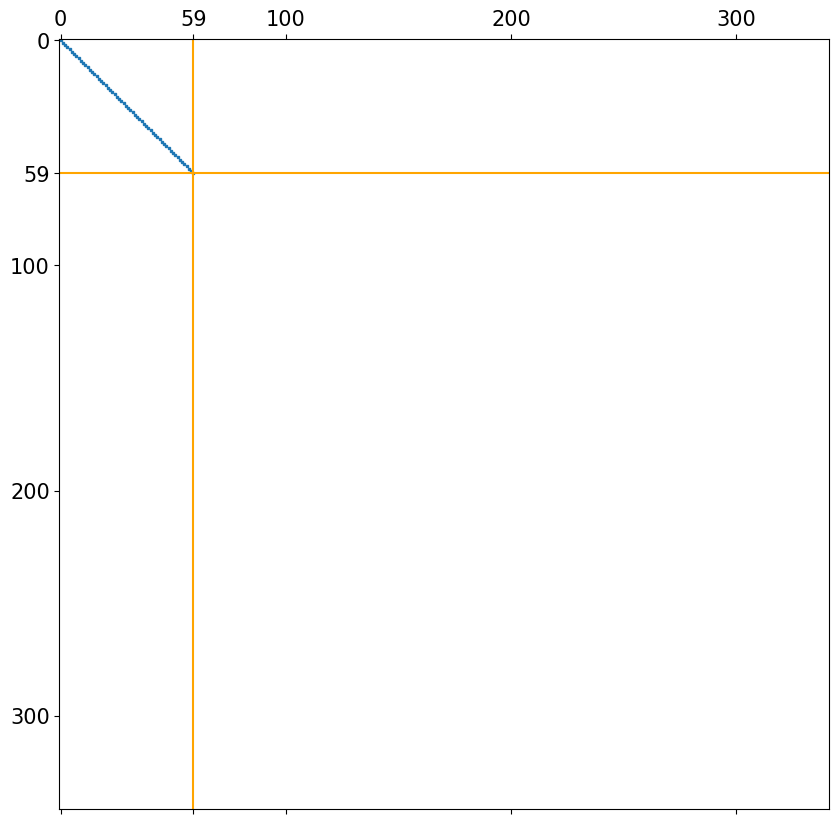

In [101]:
last_non_zero = np.where(np.diag(S_ht_reg_dag) @ np.diag(S_ht_reg) > eps_rel_Ht)[-1][-1]

plt.figure(figsize=(15,10))
plt.spy(np.diag(S_ht_reg_dag) @ np.diag(S_ht_reg), precision=eps_rel_Ht, markersize=2)
plt.plot(np.linspace(0, H_tilde.shape[0],100), [last_non_zero for _ in range(100)], label=r'$\varepsilon_{rel}$' +  f'~{eps_rel_Ht:.2e}', color='orange')
plt.plot([last_non_zero for _ in range(100)], np.linspace(0, H_tilde.shape[0],100), label=r'$\varepsilon_{rel}$' +  f'~{eps_rel_Ht:.2e}', color='orange')
_ = plt.xticks(ticks=[0, 100, 200, 300, last_non_zero], fontsize=15)
_ = plt.yticks(ticks=[0, 100, 200, 300, last_non_zero], fontsize=15)

In [102]:
is_U_orth = np.allclose(U_ht.T @ U_ht, np.eye(U_ht.shape[0]), atol=eps_rel_Ht)
is_V_orth = np.allclose(Vh_ht.T @ Vh_ht, np.eye(Vh_ht.shape[0]), atol=eps_rel_Ht)
print(f"U is orthogonal: {is_U_orth}")
print(f"V is orthogonal: {is_V_orth}")

U is orthogonal: True
V is orthogonal: False


Check that $U^T U = 1$ and $V^T V = 1$ using `plt.spy`

NameError: name 'reg_eta' is not defined

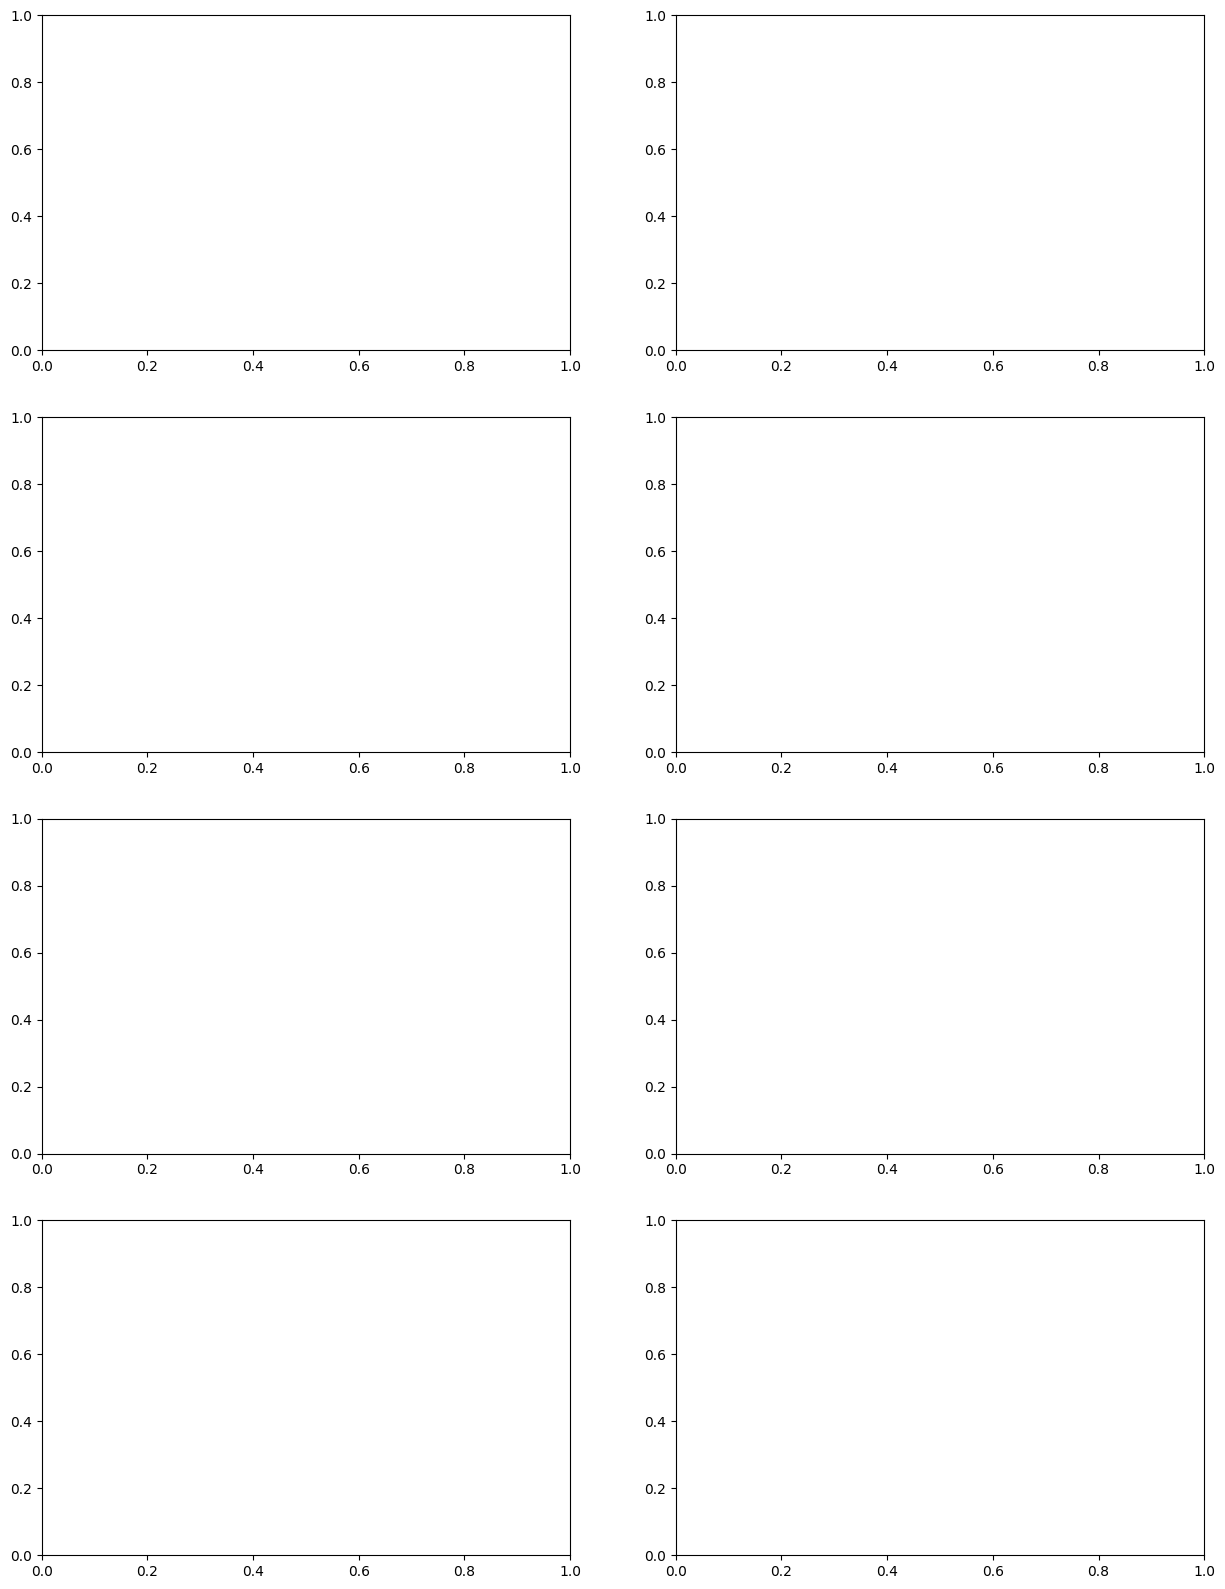

In [103]:
fig, axs = plt.subplots(4, 2, figsize=(15,20))

axs[0,0].spy(U_ht.T @ U_ht, precision=reg_eta, markersize=2)
axs[0,1].spy(U_ht.T @ U_ht, markersize=2)
axs[0,0].set_title(r'$U^T U$ with $\epsilon \sim$' + f'{reg_eta:.2e}')
axs[0,1].set_title(r'$U^T U$ with $\epsilon = 0$')

axs[1,0].spy(Vh_ht.T @ Vh_ht, precision=reg_eta, markersize=2)
axs[1,1].spy(Vh_ht.T @ Vh_ht, markersize=2)
axs[1,0].set_title(r'$V^T V$ with $\epsilon \sim$' + f'{reg_eta:.2e}')
axs[1,1].set_title(r'$V^T V$ with $\epsilon = 0$')

axs[2,0].spy(np.diag(S_ht_reg_dag) @ (U_ht.T @ U_ht) @ np.diag(S_ht_reg), precision=reg_eta, markersize=2)
axs[2,1].spy(np.diag(S_ht_reg_dag) @ (U_ht.T @ U_ht) @ np.diag(S_ht_reg), markersize=2)
axs[2,0].set_title(r'$S^{\dag} U^T U S$ with $\epsilon =$' + f'{reg_eta:.2e}')
axs[2,1].set_title(r'$S^{\dag} U^T U S$ with $\epsilon = 0$')

axs[3,0].spy(Vh_ht.T @ np.diag(S_ht_reg_dag) @ (U_ht.T @ U_ht) @ np.diag(S_ht_reg) @ Vh_ht, precision=reg_eta, markersize=2)
axs[3,1].spy(Vh_ht.T @ np.diag(S_ht_reg_dag) @ (U_ht.T @ U_ht) @ np.diag(S_ht_reg) @ Vh_ht, markersize=2)
axs[3,0].set_title(r'$V S^{\dag} U^T U S V^T$ with $\epsilon =$' + f'{reg_eta:.2e}')
axs[3,1].set_title(r'$V S^{\dag} U^T U S V^T$ with $\epsilon = 0$')

# $\tilde{H_{\epsilon}} = D_Y^{1/2} R_Y^T (FK) \Theta (FK)^T R_Y D_Y^{1/2}$

In [104]:
# Compute H_eps_tilde and make a copy
Hte = np.sqrt(D_Y) @ R_Y.T @ FK @ ntk @ FK.T @ R_Y @ np.sqrt(D_Y)

# Compute SVD
U_hte, S_hte, Vh_hte = np.linalg.svd(Hte, full_matrices=True, hermitian=True)

print(f"Max. singular value : {S_hte[0]:.2e}")
assert(np.allclose(Hte, Hte.T))

Max. singular value : 5.07e+04


In [105]:
eigvals_Hte, eigvecs_Hte = np.linalg.eigh(Hte)
eigvals_Hte = eigvals_Hte[::-1]
eigvecs_Hte = eigvecs_Hte[:, ::-1]

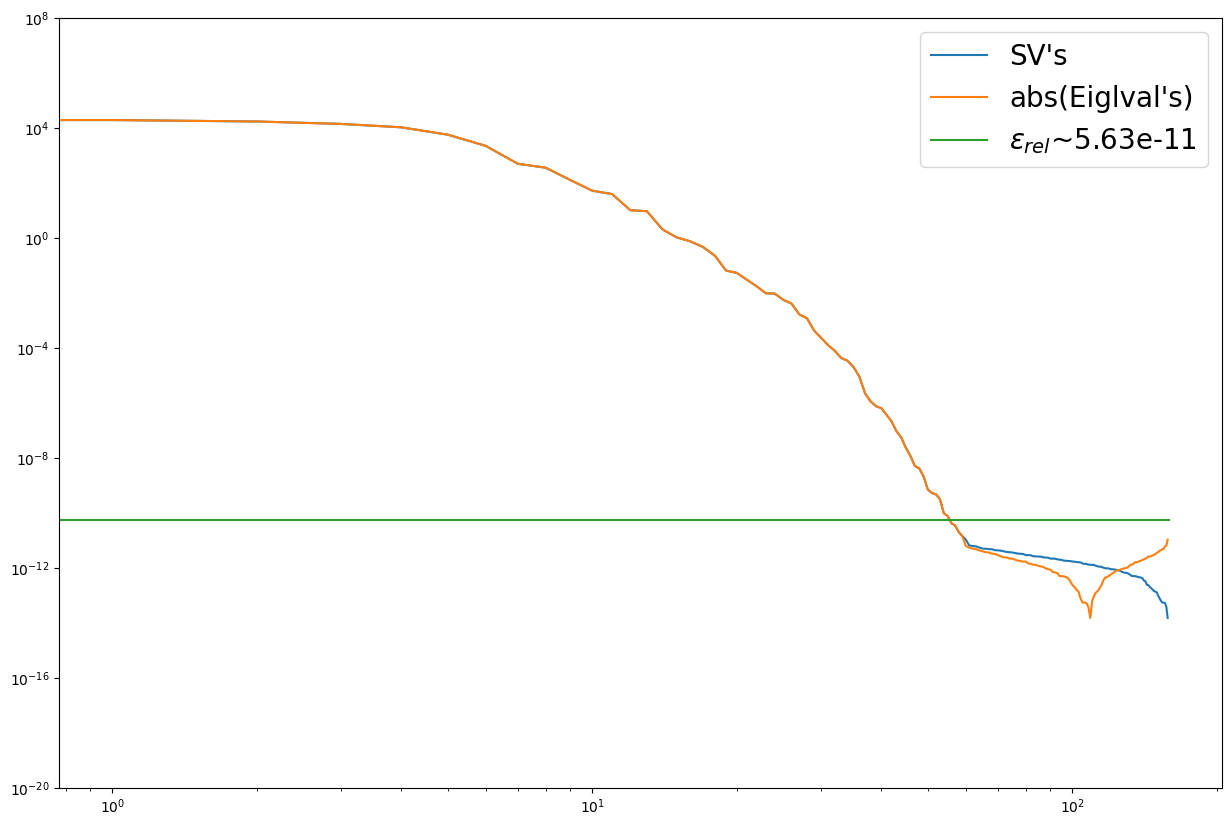

In [106]:
eps_rel_hte = eps * S_hte[0] * 5

plt.figure(figsize=(15,10))
plt.plot(S_hte, label="SV's")
plt.plot(np.abs(eigvals_Hte), label="abs(Eiglval's)")
plt.plot(np.linspace(0,eigvals_Hte.size,100), [eps_rel_hte for _ in range(100)], label=r'$\varepsilon_{rel}$' +  f'~{eps_rel_hte:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1.e-20,1.e8])
plt.legend(fontsize=20)

In [107]:
# Regularize the matrix
Hte, (S_hte_reg, Vh_hte, U_hte, tol) = regularize_matrix_svd(Hte, tol=eps_rel_hte, hermitean=True)

# Regularize the eigenvalues
eigvals_Hte = [val if val > eps_rel_hte else 0.0 for val in eigvals_Hte]

# Reconstruct the pseudo-inverse
S_hte_reg_dag = [1/val if val != 0.0 else 0.0 for val in S_hte_reg]
Hte_my_pinv = Vh_hte.T @ np.diag(S_hte_reg_dag) @ U_hte.T

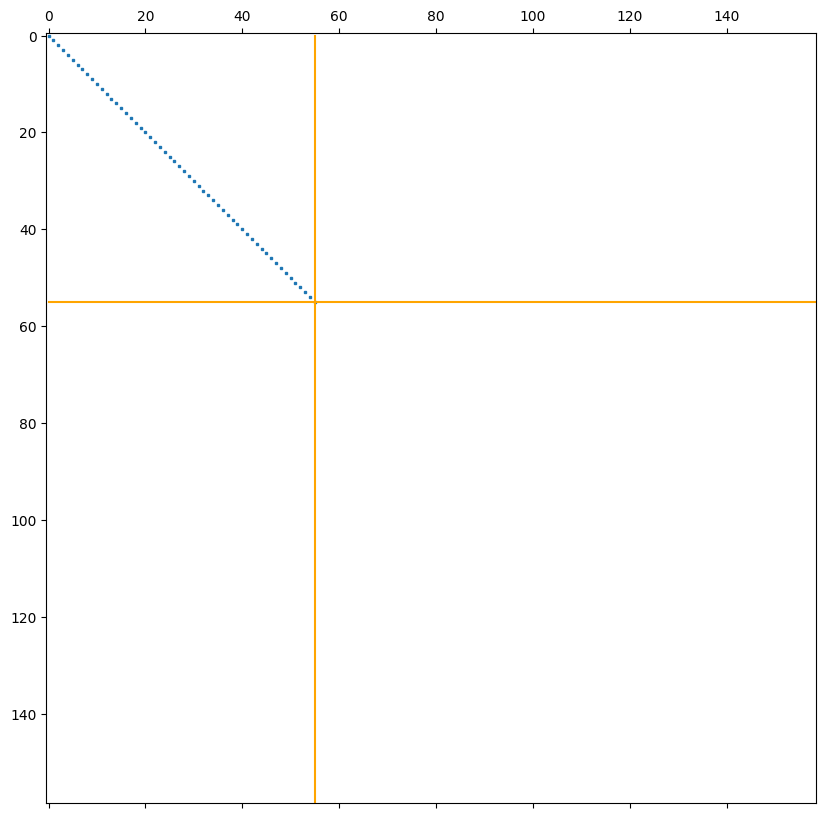

In [108]:
last_non_zero = np.where(np.diag(S_hte_reg_dag) @ np.diag(S_hte_reg) > eps_rel_hte)[-1][-1]

plt.figure(figsize=(15,10))
plt.spy(np.diag(S_hte_reg_dag) @ np.diag(S_hte_reg), precision=eps_rel_hte, markersize=2)
plt.plot(np.linspace(0, Hte.shape[0],100), [last_non_zero for _ in range(100)], label=r'$\varepsilon_{rel}$' +  f'~{eps_rel_hte:.2e}', color='orange')
plt.plot([last_non_zero for _ in range(100)], np.linspace(0, Hte.shape[0],100), label=r'$\varepsilon_{rel}$' +  f'~{eps_rel_hte:.2e}', color='orange')

In [109]:
is_U_orth = np.allclose(U_hte.T @ U_hte, np.eye(U_hte.shape[0]), atol=eps_rel_hte)
is_V_orth = np.allclose(Vh_hte.T @ Vh_hte, np.eye(Vh_hte.shape[0]), atol=eps_rel_hte)
print(f"U is orthogonal: {is_U_orth}")
print(f"V is orthogonal: {is_V_orth}")

U is orthogonal: True
V is orthogonal: True


Text(0.5, 1.0, '$V S^{\\dag} U^T U S V^T$ with $\\epsilon = 0$')

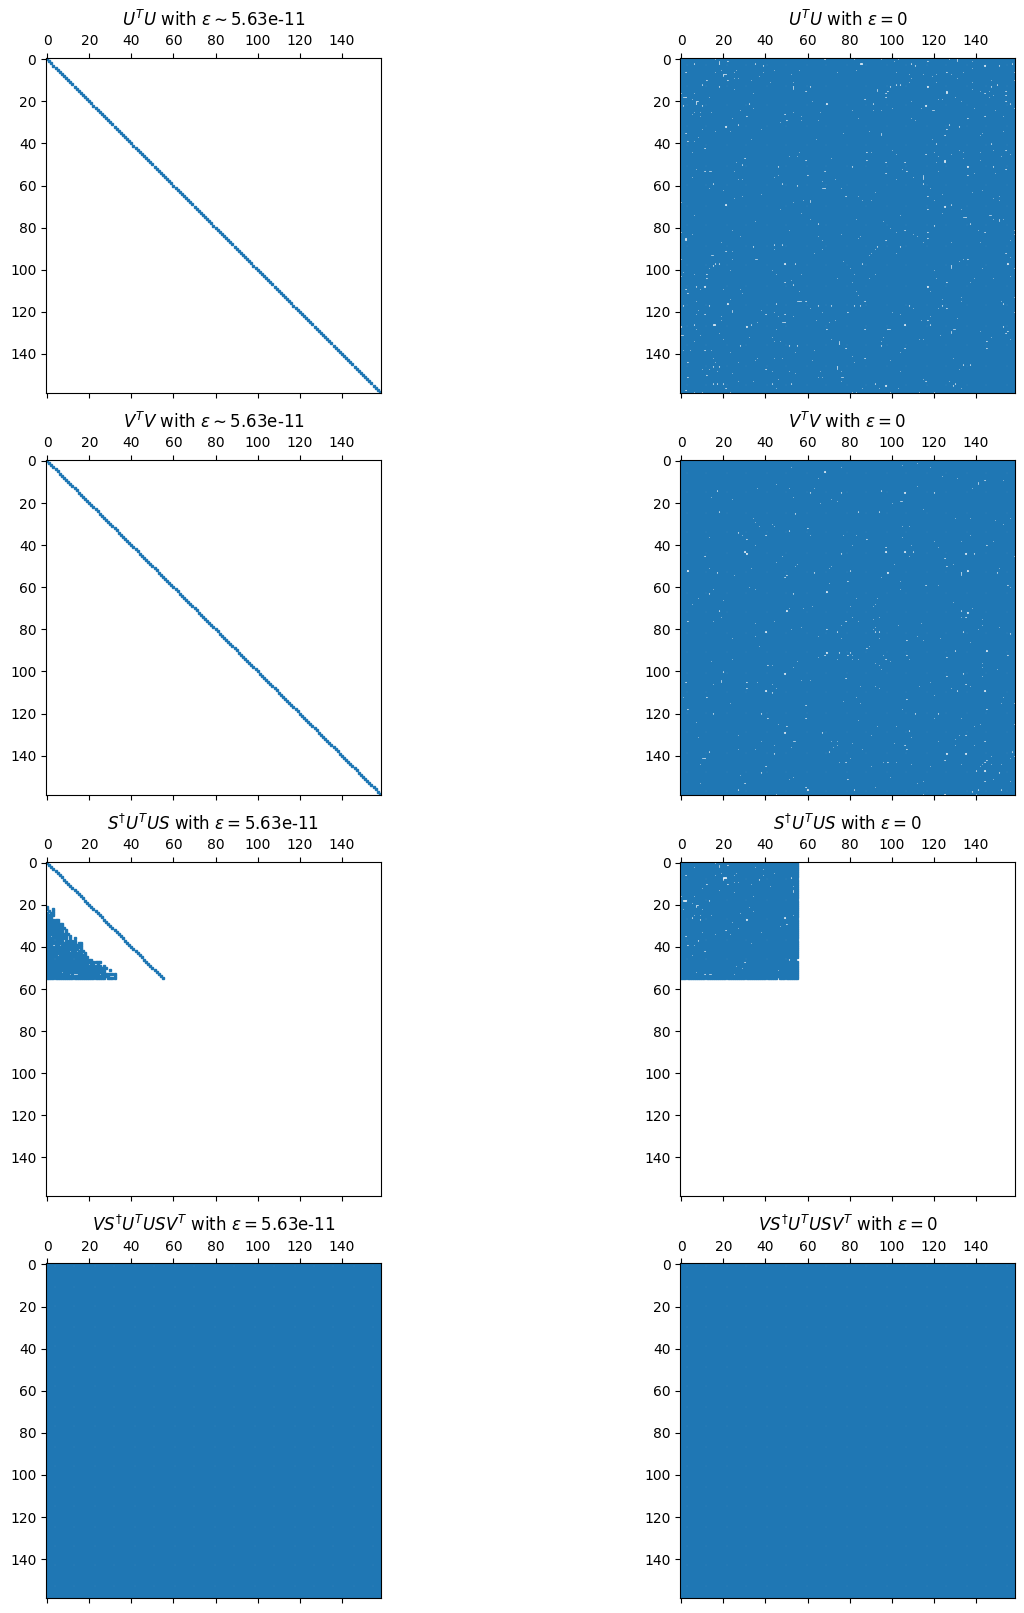

In [110]:
fig, axs = plt.subplots(4, 2, figsize=(15,20))

axs[0,0].spy(U_hte.T @ U_hte, precision=eps_rel_hte, markersize=2)
axs[0,1].spy(U_hte.T @ U_hte, markersize=2)
axs[0,0].set_title(r'$U^T U$ with $\epsilon \sim$' + f'{eps_rel_hte:.2e}')
axs[0,1].set_title(r'$U^T U$ with $\epsilon = 0$')

axs[1,0].spy(Vh_hte.T @ Vh_hte, precision=eps_rel_hte, markersize=2)
axs[1,1].spy(Vh_hte.T @ Vh_hte, markersize=2)
axs[1,0].set_title(r'$V^T V$ with $\epsilon \sim$' + f'{eps_rel_hte:.2e}')
axs[1,1].set_title(r'$V^T V$ with $\epsilon = 0$')

axs[2,0].spy(np.diag(S_hte_reg_dag) @ (U_hte.T @ U_hte) @ np.diag(S_hte_reg), precision=eps_rel_hte, markersize=2)
axs[2,1].spy(np.diag(S_hte_reg_dag) @ (U_hte.T @ U_hte) @ np.diag(S_hte_reg), markersize=2)
axs[2,0].set_title(r'$S^{\dag} U^T U S$ with $\epsilon =$' + f'{eps_rel_hte:.2e}')
axs[2,1].set_title(r'$S^{\dag} U^T U S$ with $\epsilon = 0$')

axs[3,0].spy(Vh_hte.T @ np.diag(S_hte_reg_dag) @ (U_hte.T @ U_hte) @ np.diag(S_hte_reg) @ Vh_hte, precision=eps_rel_hte, markersize=2)
axs[3,1].spy(Vh_hte.T @ np.diag(S_hte_reg_dag) @ (U_hte.T @ U_hte) @ np.diag(S_hte_reg) @ Vh_hte, markersize=2)
axs[3,0].set_title(r'$V S^{\dag} U^T U S V^T$ with $\epsilon =$' + f'{eps_rel_hte:.2e}')
axs[3,1].set_title(r'$V S^{\dag} U^T U S V^T$ with $\epsilon = 0$')

# $b = \Theta (FK)^T C_Y^{-1} y \hspace{5mm} \textrm{and} \hspace{5mm} \tilde{b} = D^{1/2} R^T b$

In [111]:
b = ntk @ FK.T @ Cinv.to_numpy(dtype='float64') @ Y.to_numpy('float64')
b_tilde = np.sqrt(D) @ eigvecs_M.T @ b

# Calculation of $f_{\infty}$, $\varepsilon_{\infty}$ and evolution
We now compute the limiting solution $f_{\infty}$, which is the value that minimizes the loss function.
$$
f_{\infty} = \mathbf{M}_{\bot\bot}^{-1} (FK)_{\bot}^T C_Y^{-1} y \,.
$$
We also compute
$$
\varepsilon_{\infty} = y - (FK)_{\bot}f_{\infty} = \biggl(1 - (FK)_{\bot} \mathbf{M}_{\bot\bot}^{-1} (FK)_{\bot}^T C_Y^{-1}\biggr) y\,,
$$
together with the minimum of the loss-function
$$
\mathcal{L}^{*} = \frac{1}{2} y^T C_Y^{-1} \varepsilon_{\infty}

In [122]:
f_inf = M_my_pinv @ FK.T @ Cinv.to_numpy(dtype='float64') @ Y.to_numpy(dtype='float64')[:,0]
eps_inf = Y.to_numpy(dtype='float64')[:,0] - FK @ f_inf
L_inf = 0.5 * Y.to_numpy(dtype='float64')[:,0].T @ Cinv.to_numpy(dtype='float64') @ eps_inf / Y.size
print(f"Normalized loss function at infinity is : {L_inf:.5e}")

Normalized loss function at infinity is : 1.53992e-01


In [124]:
f_inf.shape[0] / 9

38.0

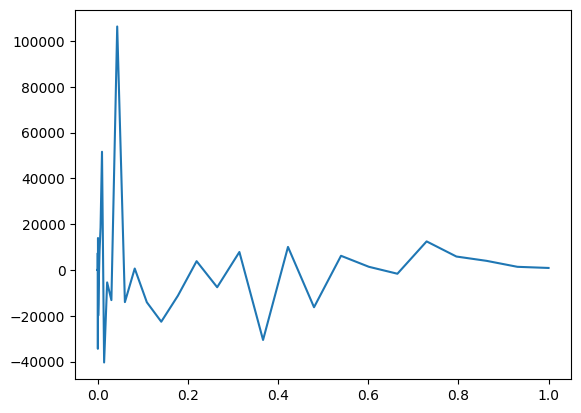

In [134]:
f_flav = f_inf.reshape((9, f_inf.shape[0] // 9))
plt.plot(XGRID, f_flav[6], label='u')

We also compute the following quantity, which will be useful in the description of the evolution
$$
\begin{align}
& \tilde{\varepsilon}_{\infty} = D_{Y}^{1/2} \, R_Y^T \varepsilon_{\infty} \hspace{5mm} \textrm{where} \hspace{5mm} C_Y^{-1} = R_Y D_Y R_Y^T \\
\end{align}
$$

In [113]:
eps_inf_tilde = np.sqrt(D_Y) @ R_Y.T @ eps_inf

# Check eq.(67)

We check the following equation
$$
(FK)^T C_Y^{-1} - (FK)^T C_Y^{-1} (FK)_{\bot} M_{\bot\bot}^{-1} (FK)_{\bot}^T C_Y^{-1} = 0
$$

In [114]:
test = FK.T @ Cinv.to_numpy(dtype='float64') - FK.T @ Cinv.to_numpy(dtype='float64') @ FK @ M_my_pinv @ FK.T @ Cinv.to_numpy(dtype='float64')

In [116]:
test.max()

88.80415072147662

We now check eq.(67) of the paper, that is
$$
\tilde{H}_{\varepsilon} \, \tilde{\varepsilon}_{\infty} = 0
$$

In [ ]:
res = Hte @ eps_inf_tilde

In [ ]:
res